#### Feedback Control

In [3]:
import matplotlib
%matplotlib inline
import pandas as pd
np = pd.np
deg2rad = np.pi / 180.

#### Sensor Measurement Error

In [4]:
def compass_measurement(true_heading, std=3*deg2rad, bias=2*deg2rad):
    std = compass_measurement.std if std is None else std 
    return (std * deg2rad * random.randn() + bias) % (2 * np.pi)
compass_measurement.std = 3*deg2rad




#### A Controller (Autopilot, Servo Control, Linear Feedback Control Law)

In [30]:
class Autopilot(object):
    
    def __init__(self, gain=.1, damping=.01, integrator=0.0001, dt=1):
        self.previous_heading_error = 0
        self.heading_error_sum = 0
        
        self.dt = dt                  # T_s
        self.gain = gain              # K_p
        self.integrator = integrator  # K_i
        self.damping = damping        # K_d
    
    def compute_rudder_angle(self, heading_error, gain=None, dt=None):
        self.gain = self.gain if gain is None else gain
        self.dt = dt or self.dt
        heading_error_rate = (heading_error - self.previous_heading_error) / self.dt
 
        self.previous_heading_error = heading_error
        self.heading_error_sum += heading_error * self.dt
        
        rudder_angle = - (self.gain * heading_error +
                          self.damping * heading_error_rate +
                          self.integrator * self.heading_error_sum
                          )
        return min(max(rudder_angle, -45 * deg2rad), +45 * deg2rad)
    
    def __call__(self, *args, **kwargs):
        return self.compute_rudder_angle(*args, **kwargs)

#### Actuator Model (ship's rudder)

<img src="rudder.JPG" style="max-height: 428px; max-width: 576px;">

<img src="hydraulic-ram.JPG" style="max-height: 428px; max-width: 576px;">

<img src="hydraulic-servo.JPG" style="max-height: 428px; max-width: 576px;">


In [31]:
def rudder_angle_turning_rate(rudder_angle):
    return min(max(0.01 * rudder_angle - 0.001 * rudder_angle ** 2, -5 * deg2rad), + 5 * deg2rad)


### Simulation
#### Initial Conditions

In [32]:
t = 0  # time
position = np.array([0., 0.]) # La Cruz Mexico = 23° 55' N / 106° 54' W
desired_heading = 225 * deg2rad  # SW
actual_heading = 0 * deg2rad
speed = 100  # 2 meter/second = 120 meters/minute = 7.2 km/h = ~= 4.5 miles/h
rudder_angle = 0  # + = starboard (right), - = port (left) 

#### Simulation Configuration Parameters


In [33]:
dt = 60  # 60 seconds between "samples"
total_samples = 1 * 24 * 60  # 30 days = ? minutes from Mexico to the Marquesas
total_time = total_samples * 60  # time in seconds... always :p

#### Initialize the Autopilot and Ship's Log

In [34]:
autopilot = Autopilot(gain=1, damping=.1, integrator=0.01)
ships_log = []

#### Run the Simulation

In [35]:
for i in range(total_samples):
    t += dt
    rudder_angle = autopilot.compute_rudder_angle(actual_heading - desired_heading) 
    actual_heading += dt * rudder_angle_turning_rate(rudder_angle)
    position += dt * speed * np.array([np.cos(actual_heading), np.sin(actual_heading)])
    # can you guess the origin of the word "log" as in "log file", "log book",  or "ship's log"?
    ships_log += [[t, position[0], position[1], desired_heading, actual_heading, rudder_angle]]
    # print(ships_log[-1])

#### Review the Log

In [36]:
df = pd.DataFrame(ships_log, columns=['time', 'x', 'y', 'desired_heading', 'actual_heading', 'rudder'])
df

,time,x,y,desired_heading,actual_heading,rudder
0,60,5443.170904,2524.260388,3.926991,0.434228,7.853982e-01
1,120,9319.207402,7104.253955,3.926991,0.868456,7.853982e-01
2,180,10908.679526,12889.889475,3.926991,1.302684,7.853982e-01
3,240,9916.565836,18807.296882,3.926991,1.736912,7.853982e-01
4,300,6527.012254,23758.147972,3.926991,2.171139,7.853982e-01
5,360,1369.152798,26823.516765,3.926991,2.605367,7.853982e-01
6,420,-4599.663791,27434.441085,3.926991,3.039595,7.853982e-01
7,480,-10271.567266,25477.527452,3.926991,3.473823,7.853982e-01
8,540,-14958.636560,21731.678892,3.926991,3.815838,6.068521e-01
9,600,-18986.573085,17284.688072,3.926991,3.976397,2.751698e-01


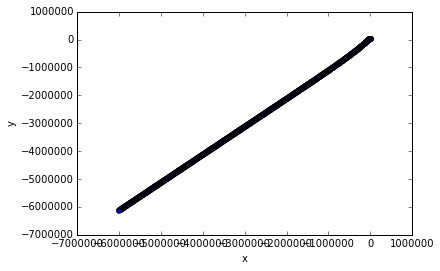

In [37]:
df.plot(kind='scatter', x='x', y='y')

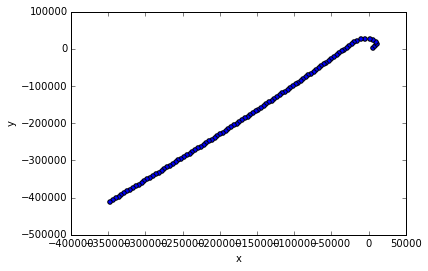

In [38]:
df[['x','y']].iloc[:100,:].plot(kind='scatter', x='x', y='y')

#### What's Wrong?

* Did we make it to the South Pacific?  
* What's wrong with the position?  
* What's wrong with the turning rate and rudder angle?  
* What can we do to fix it?  

<img src="nuka-hiva.JPG">